In [15]:
#Visualization threshold
threshold = 3.091

#Weight feature type. 'avg' or 'sum'
wf_type = 'avg'

#Whether to save WFM or not
save = False

## Make ROIs x ROIs WFM

In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import torch

import warnings
warnings.filterwarnings(action='ignore')

In [17]:
#Pre-trained SGNN
pre_trained_path = "/users/hjd/HJW_take_over/SNUH_hjd/best_models_for_manuscript/pretrain_model/Hsp:[0.95,0.3,0.3]_Maxb:[0.01, 0.05, 0.05]_Betalr:[0.0001, 0.001, 0.001]_LR:[5e-05]_Act:[elu]_Opt:[nag]_DO:[0.9,0.9,0.0]_lambda:[0.01]"

#Transferred DNN
transferred_path ="/users/hjd/HJW_take_over/SNUH_hjd/best_models_for_manuscript/transfer/pretrain:True_trainext:False_trainprd:True/"

#Choose model to visualize
root_path = transferred_path

fold_list = [fold for fold in os.listdir(root_path) if 'Outer_fold' in fold and "Full" not in fold]

In [18]:
#Average weight features of folds
w_ext = []
w_reg = []
w_dsc = []

for n_outer_cv, temp_folder in enumerate(fold_list):
    outer_save_dir = "{}/Outer_fold_{}".format(root_path, n_outer_cv + 1)
    model_path = outer_save_dir + "/model_fold_" + str(n_outer_cv + 1) + ".pt"
    if not os.path.exists(model_path):
        break

    trained_model = torch.load(model_path, map_location="cpu")
    w = []
    
    print("{}".format(n_outer_cv + 1), end=" ")

    for name in trained_model:
        if "weight" in name and "bn" not in name:
                w.append(trained_model[name])
    
    w_ext_1 = w[0].detach().cpu().numpy().T
    w_reg_1 = w[1].detach().cpu().numpy().T
    w_reg_2 = w[2].detach().cpu().numpy().T

    temp_w_ext = w_ext_1
    temp_w_reg = np.matmul(np.matmul(temp_w_ext, w_reg_1), w_reg_2)

    if 'pretrain_model' in root_path:
        w_dsc_1 = w[3].detach().cpu().numpy().T
        w_dsc_2 = w[4].detach().cpu().numpy().T
        temp_w_dsc = np.matmul(np.matmul(temp_w_ext,w_dsc_1),w_dsc_2[:,0:1])
        w_dsc.append(temp_w_dsc)
        
    w_ext.append(temp_w_ext)
    w_reg.append(temp_w_reg)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

In [19]:
w_reg = np.array(w_reg).reshape(np.shape(w_reg)[0],-1)
w_reg_avg = np.mean(w_reg, axis=0)

print(w_reg.shape, w_reg_avg.shape)

(20, 61776) (61776,)


## Designate 352ROIs =>  14FNs

In [20]:
# Preparing draw feature map
parcels = pd.read_excel("/users/hjw/data/ABCD/Parcels/Parcels.xlsx", engine="openpyxl")
networks = list(parcels["Community"]) + 19 * ["Subcortex"]

In [21]:
networks_df = pd.DataFrame(networks, columns=["network"])
networks_df[networks_df["network"] == "Auditory"] = "AUD"
networks_df[networks_df["network"] == "Visual"] = "VIS"
networks_df[networks_df["network"] == "VentralAttn"] = "VAN"
networks_df[networks_df["network"] == "Subcortex"] = "SCN"
networks_df[networks_df["network"] == "Salience"] = "SAL"
networks_df[networks_df["network"] == "SMmouth"] = "SMM"
networks_df[networks_df["network"] == "SMhand"] = "SMH"
networks_df[networks_df["network"] == "RetrosplenialTemporal"] = "RSP"
networks_df[networks_df["network"] == "None"] = "NONE"
networks_df[networks_df["network"] == "FrontoParietal"] = "FPN"
networks_df[networks_df["network"] == "DorsalAttn"] = "DAN"
networks_df[networks_df["network"] == "Default"] = "DMN"
networks_df[networks_df["network"] == "CinguloParietal"] = "CPAR"
networks_df[networks_df["network"] == "CinguloOperc"] = "CON"

In [22]:
orig_networks = networks_df['network'].tolist()
networks_label = sorted(np.unique(networks_df['network'].values))
new_networks_label = networks_label.copy()
new_networks_label.remove("NONE")
new_networks_label.append("NONE")

new_orig_network_order = {
    key:value for (key, value) in 
    zip(new_networks_label, (np.arange(len(new_networks_label))))
}

In [23]:
sorted_networks = pd.DataFrame(index=orig_networks).sort_index(key=lambda x: x.map(new_orig_network_order), axis=0).index.tolist()
sorted_networks_df = pd.DataFrame(np.unique(sorted_networks, return_index=True)).T
sorted_networks_df.columns = ["networks", "n"]
sorted_networks_df = sorted_networks_df.sort_values(
    by="networks", key=lambda x: x.map(new_orig_network_order)
)

start_network_idx = np.array(sorted_networks_df.n)
next_network_idx = np.hstack((start_network_idx[1:], 352))

network_mid_idx = np.array((start_network_idx + next_network_idx) / 2, dtype=np.int)

In [24]:
def make_wfm(vec):
    num_ROIs = tot_rois = 352
    wfm = np.zeros((tot_rois, tot_rois))
    iu_non_di_idx = np.mask_indices(tot_rois, np.triu, 1)
    wfm[iu_non_di_idx] = vec
    il_idx = np.tril_indices(tot_rois, -1)
    wfm[il_idx] = wfm.T[il_idx]
    wfm_df = pd.DataFrame(wfm, index=orig_networks, columns=orig_networks)
    wfm_df = wfm_df.sort_index(key=lambda x: x.map(new_orig_network_order), axis=0)
    wfm_df = wfm_df.sort_index(key=lambda x: x.map(new_orig_network_order), axis=1)
    
    return wfm_df

In [25]:
# z_w = stats.zscore(w_reg_avg)
# w_reg_avg[np.where(np.abs(z_w)<threshold)[0]]=0
# wfm_df=make_wfm(w_reg_avg)

wfm_df = make_wfm(stats.zscore(w_reg_avg))
# wfm_df = make_wfm(w_reg_avg)


if 'pretrain_model' in root_path:
    w_dsc = np.array(w_dsc).reshape(np.shape(w_dsc)[0],-1)
    w_dsc_avg = np.mean(w_dsc, axis=0)
    wfm_df_dsc = make_wfm(stats.zscore(w_dsc_avg))

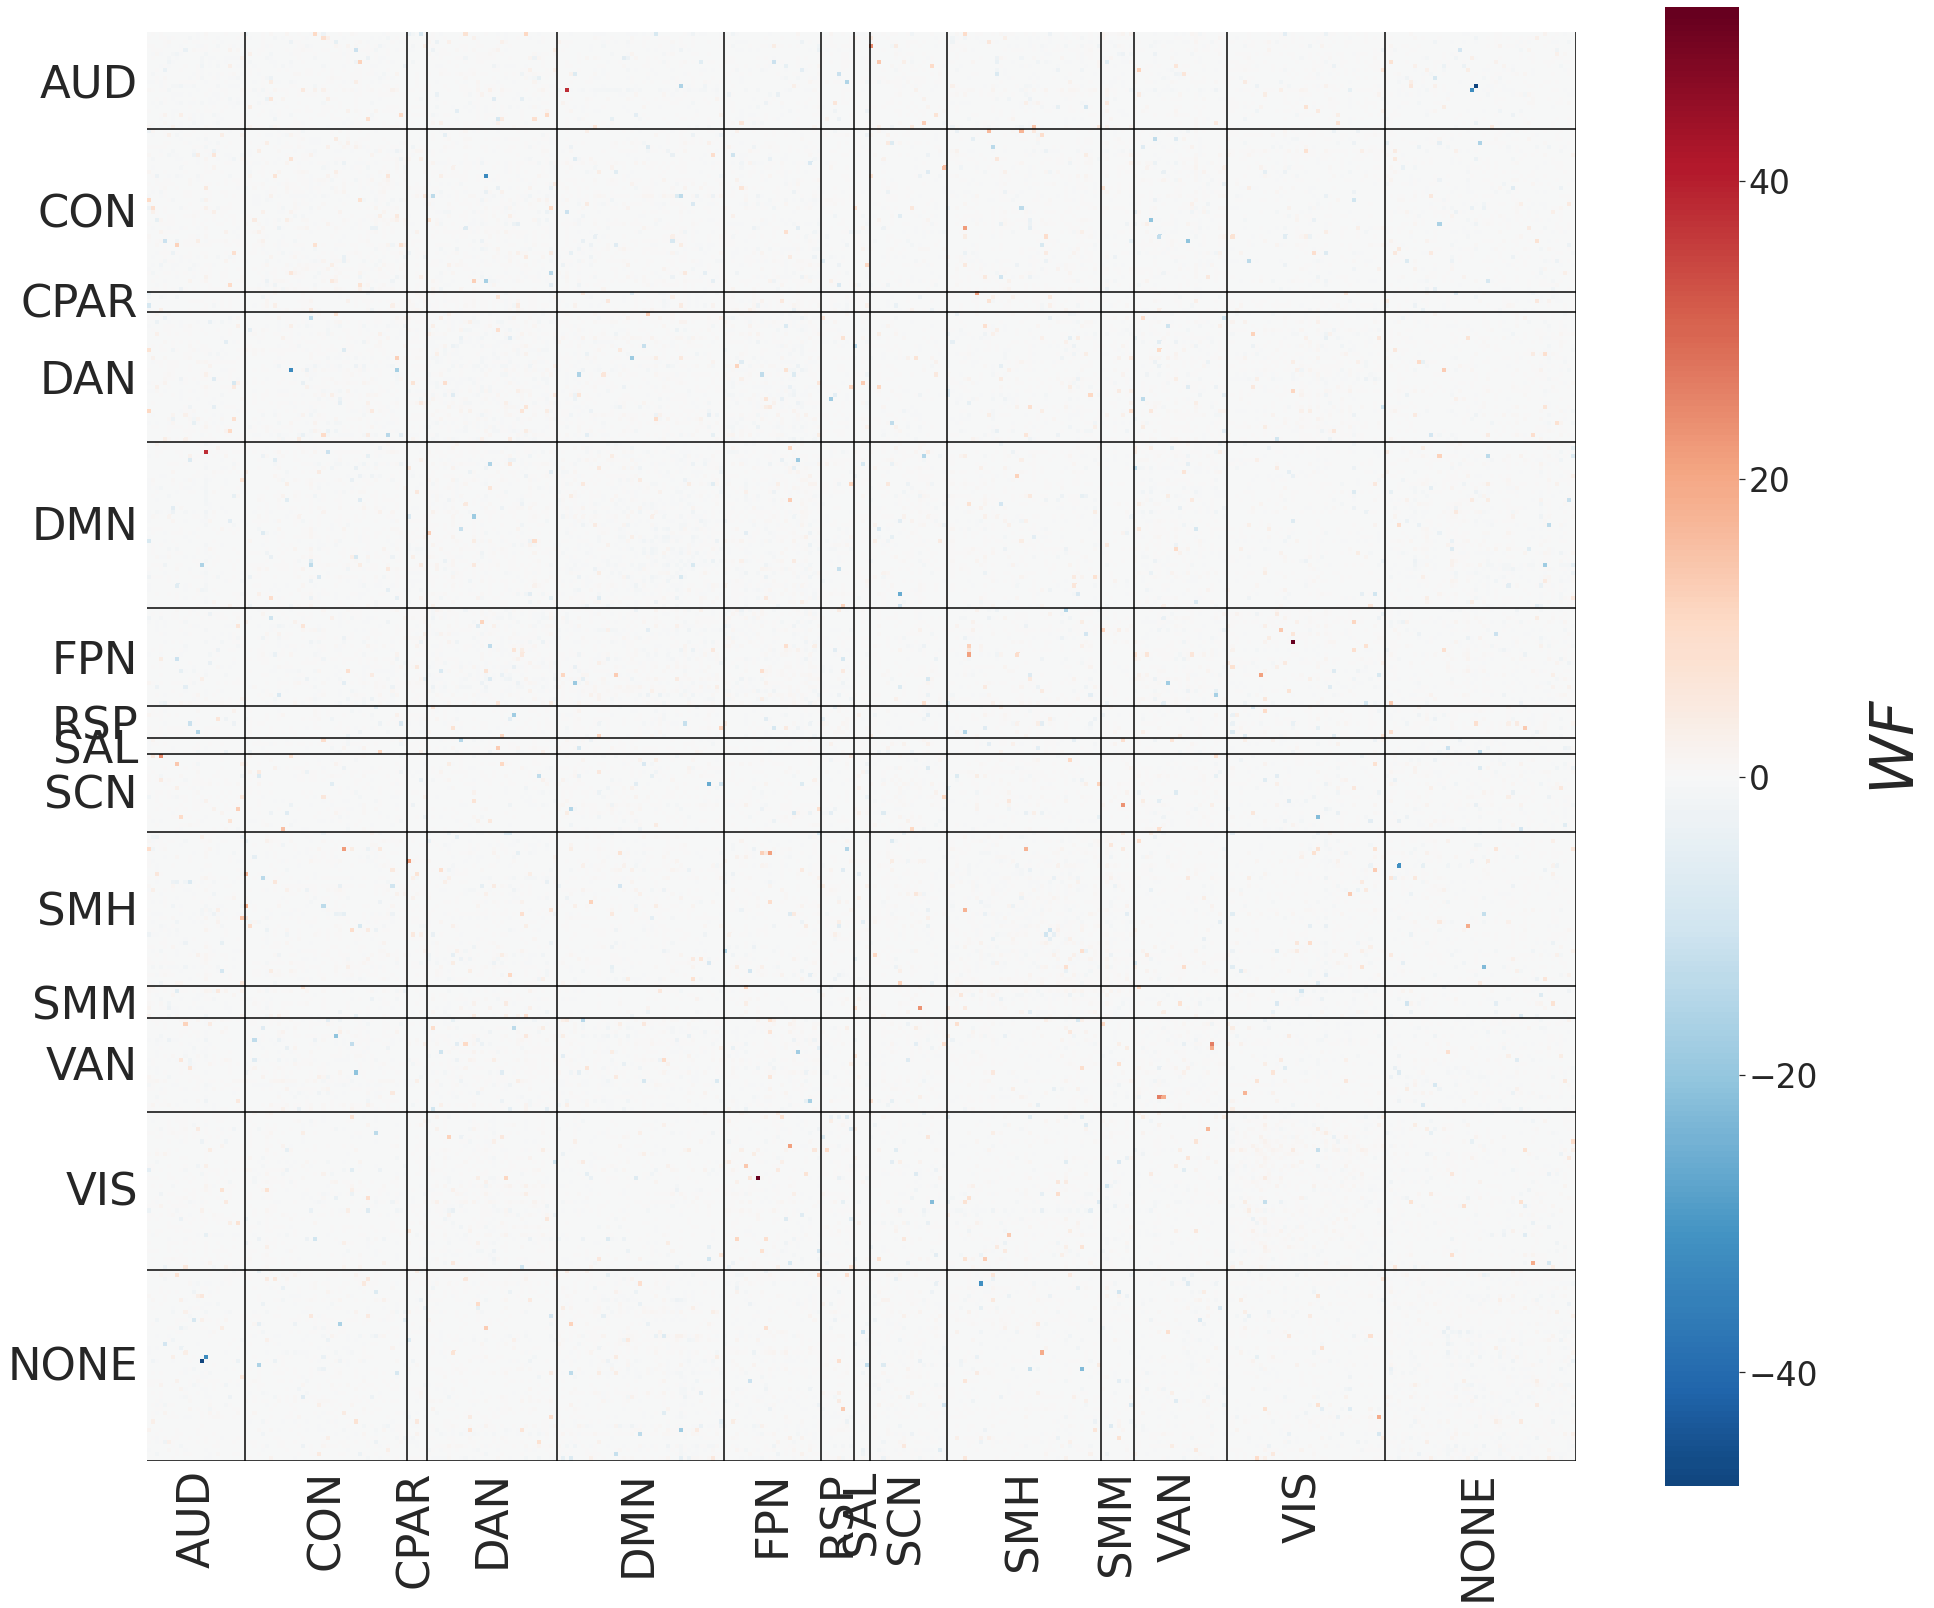

In [26]:
sns.set(style="white", font_scale=3)
fig, ax = plt.subplots(figsize=(32, 32))
cbar_kws = dict(use_gridspec=False, shrink=0.85, location="right")

sns.heatmap(
    wfm_df, square=True, cmap="RdBu_r", center=0, 
#     vmax=threshold, vmin=-threshold , 
    ax=ax, cbar_kws=cbar_kws
)

ax.set_xticks(network_mid_idx)
ax.set_yticks(network_mid_idx)

ax.set_xticklabels(new_networks_label, rotation=90, fontsize=45, ha="center")
ax.set_yticklabels(new_networks_label, rotation='horizontal', fontsize=45)

for network_pos in next_network_idx:
    plt.axvline(network_pos, linewidth=1.5, color="black", ymin=0, ymax=network_pos)
    plt.axhline(network_pos, linewidth=1.5, color="black", xmin=0, xmax=network_pos)

cbar = ax.collections[0].colorbar
cbar.set_label("$WF$", fontsize=60, labelpad=50)

## Visualize WFM into 14FNs

In [27]:
cols = rows = wfm_df.columns.values
unqs = new_networks_label
avg_df_1 = pd.DataFrame(columns=cols, index=rows)
avg_df_2 = pd.DataFrame(columns=unqs, index=unqs)
avg_df_3 = pd.DataFrame(columns=unqs, index=unqs)

for i, temp_row in enumerate(unqs):
    for j, temp_col in enumerate(unqs):
        
        temp_row_ids = np.where(rows == temp_row)[0]
        temp_col_ids = np.where(cols == temp_col)[0]
        temp_mat = wfm_df.iloc[temp_row_ids, temp_col_ids]
        temp_vec = temp_mat.values.ravel()
        temp_sig_vec = temp_vec[(np.absolute(temp_mat.values) > 3.091).ravel()]
        
        if wf_type == 'sum':
            avg_val = temp_vec.sum()
            n_val = np.sum(temp_sig_vec)
        if wf_type == 'avg':
            if temp_row == temp_col:
                avg_val = temp_vec.sum() / (len(temp_row) * (len(temp_col) - 1))
            else:
                avg_val = temp_vec.sum() / (len(temp_row) * (len(temp_col)))
            n_val = 0 if np.sum(temp_sig_vec)==0 else np.mean(temp_sig_vec)

        avg_df_1.iloc[temp_row_ids, temp_col_ids] = avg_val
        avg_df_2.loc[temp_row, temp_col] = avg_val
        avg_df_3.loc[temp_row, temp_col] = n_val
        
if 'pretrain_model' in root_path:
    cols = rows = wfm_df_dsc.columns.values
    unqs = new_networks_label
    avg_df_dsc_1 = pd.DataFrame(columns=cols, index=rows)
    avg_df_dsc_2 = pd.DataFrame(columns=unqs, index=unqs)
    avg_df_dsc_3 = pd.DataFrame(columns=unqs, index=unqs)


    for i, temp_row in enumerate(unqs):
        for j, temp_col in enumerate(unqs):

            temp_row_ids = np.where(rows == temp_row)[0]
            temp_col_ids = np.where(cols == temp_col)[0]
            temp_mat = wfm_df_dsc.iloc[temp_row_ids, temp_col_ids]
            temp_vec = temp_mat.values.ravel()
            temp_sig_vec = temp_vec[(np.absolute(temp_mat.values) > 3.091).ravel()]

            if wf_type == 'sum':
                avg_val = temp_vec.sum()
                n_val = np.sum(temp_sig_vec)
            if wf_type == 'avg':
                if temp_row == temp_col:
                    avg_val = temp_vec.sum() / (len(temp_row) * (len(temp_col) - 1))
                else:
                    avg_val = temp_vec.sum() / (len(temp_row) * (len(temp_col)))
                n_val = 0 if np.sum(temp_sig_vec)==0 else np.mean(temp_sig_vec)

            avg_df_dsc_1.iloc[temp_row_ids, temp_col_ids] = avg_val
            avg_df_dsc_2.loc[temp_row, temp_col] = avg_val
            avg_df_dsc_3.loc[temp_row, temp_col] = n_val

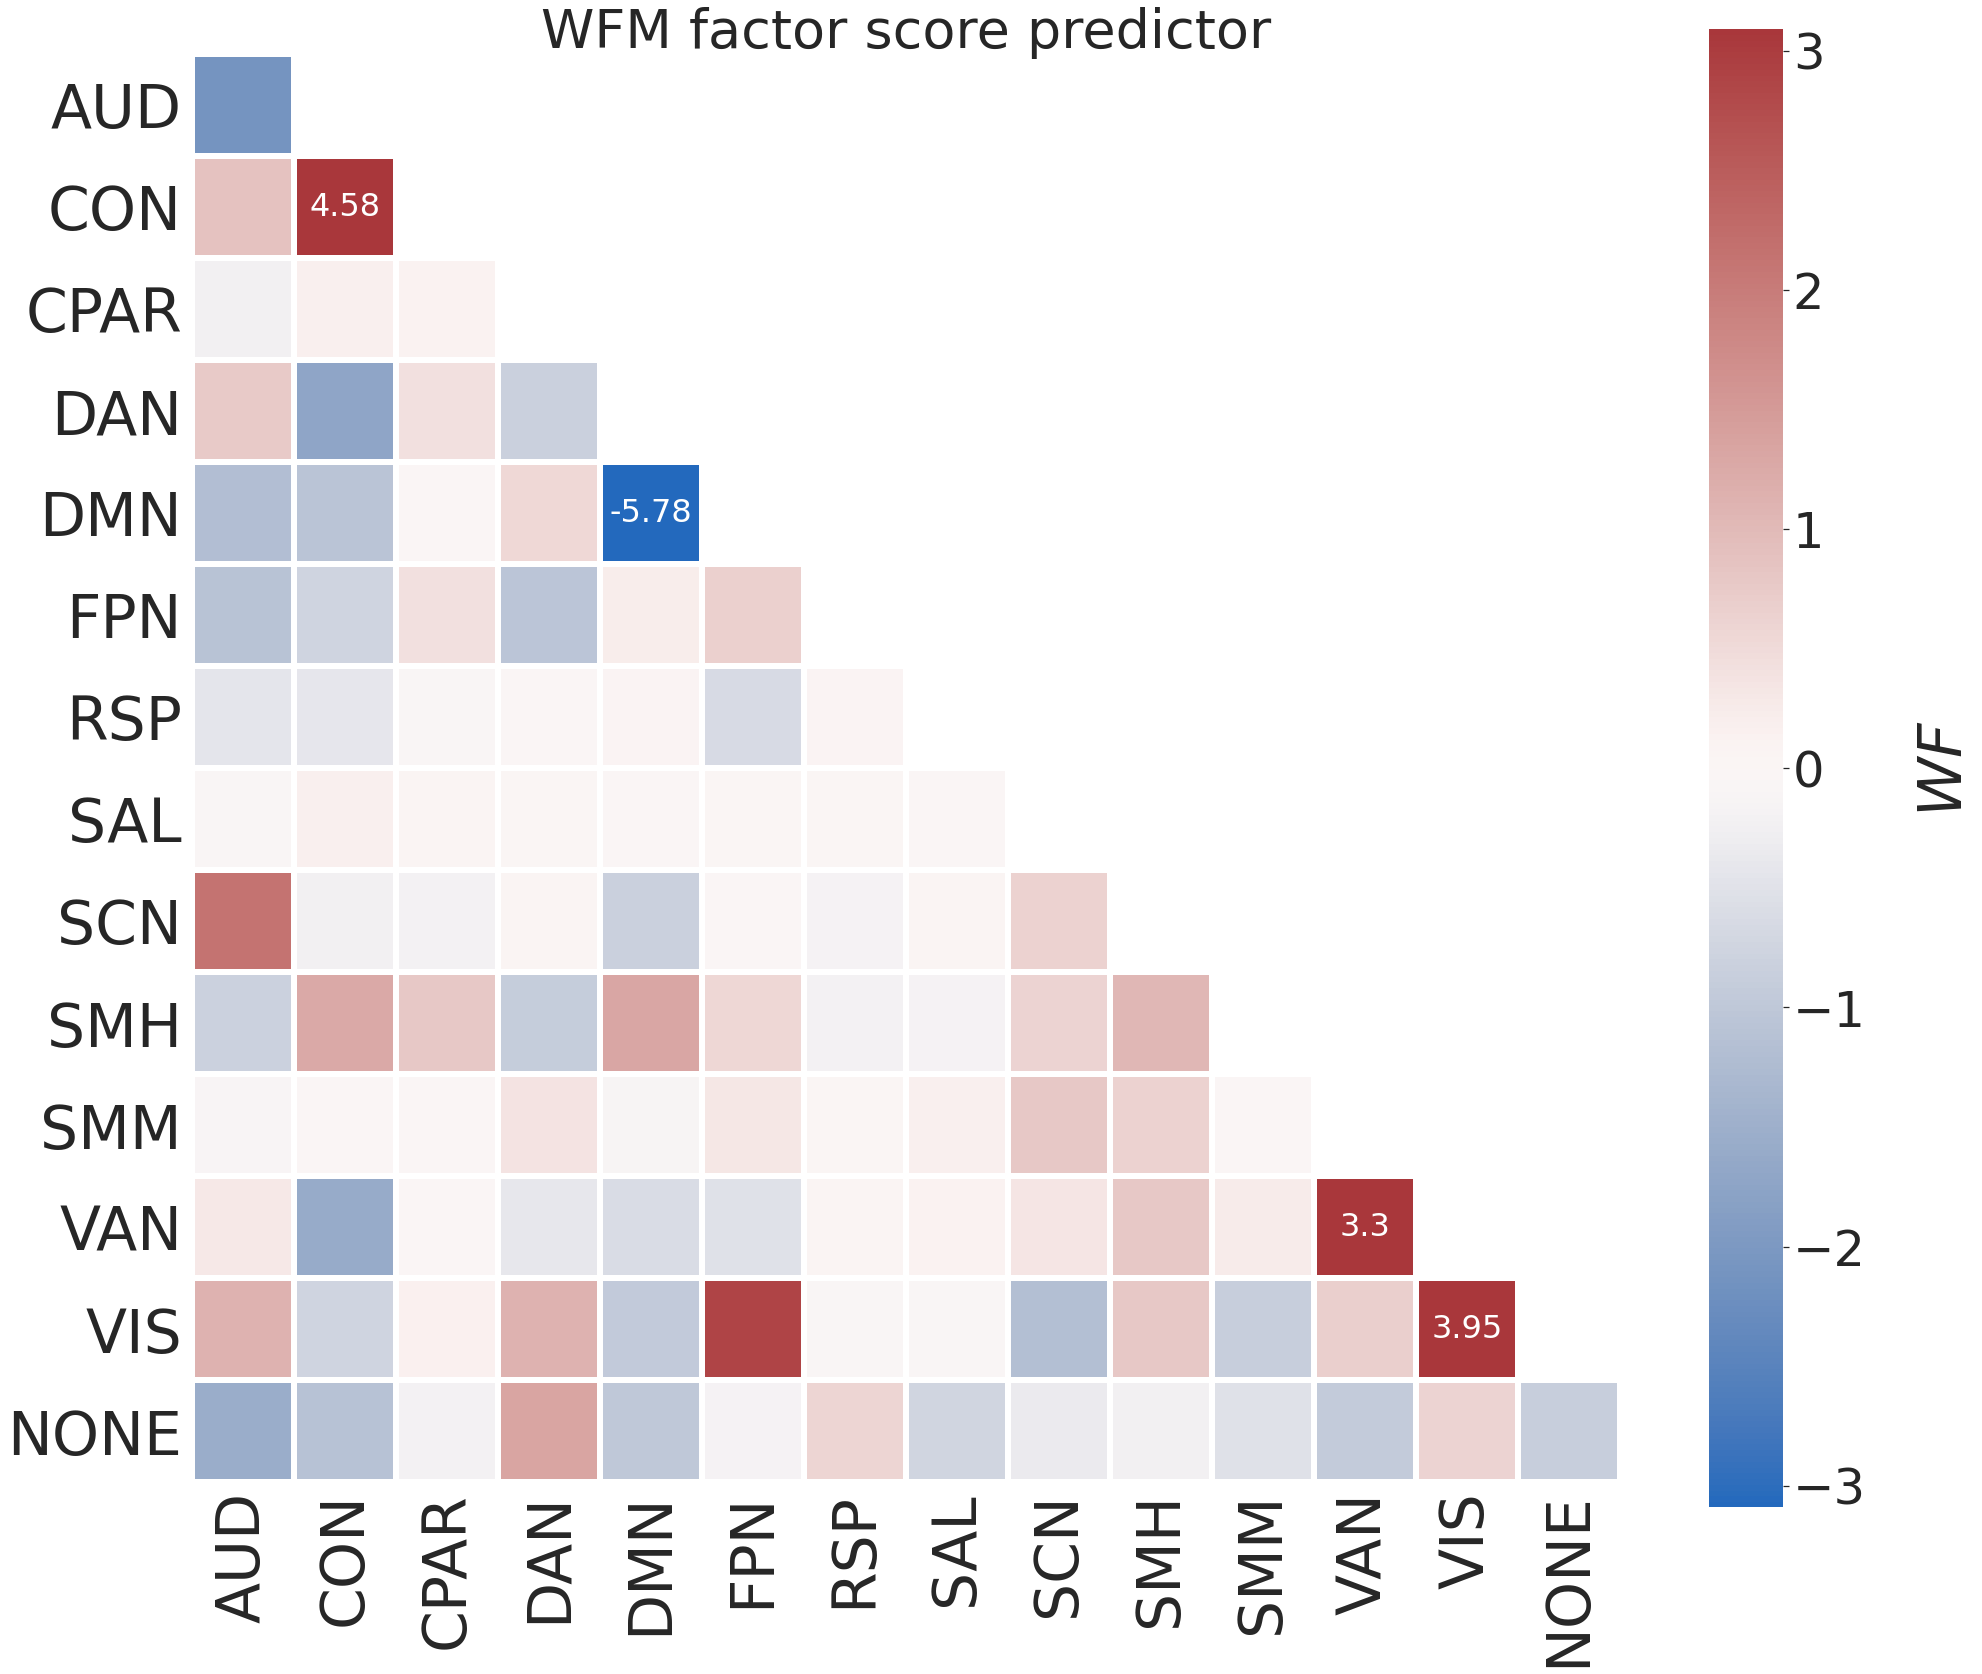

In [28]:
avg_mat2 = np.array(avg_df_2.values, dtype=np.float)
avg_mat2 = (avg_mat2 - avg_mat2.mean()) / avg_mat2.std()
avg_mat2_df = pd.DataFrame(avg_mat2, columns=avg_df_2.columns, index=avg_df_2.index)
thr_zero = 0
avg_mat2_df[(avg_mat2_df < thr_zero) & (avg_mat2_df > -thr_zero)] = 0

sns.set(style="white", font_scale=4.5)
fig, ax = plt.subplots(figsize=(32, 32))
plt.title("WFM factor score predictor")

annot = np.vectorize(lambda x: '' if np.absolute(x) < 3.091 else str(round(x, 2)))(avg_mat2_df.to_numpy())
# annot = np.vectorize(lambda x: '' if np.absolute(x) < 2.58 else str(round(x, 2)))(avg_mat2_df.to_numpy())
# annot = np.vectorize(lambda x: '' if np.absolute(x) < 1.96 else str(round(x, 2)))(avg_mat2_df.to_numpy())


##Using whole ROIs - p-factor###
threshold = 3.091
cbar_kws = dict(
    use_gridspec=False, shrink=0.85, location="right", label="Correlation ($r$)")
sns.heatmap(
    avg_mat2_df, square=True, cmap="vlag", ax=ax, 
    mask=np.triu(np.ones(avg_mat2_df.shape), 1).astype(np.bool),
    vmax=threshold, vmin=-threshold, 
    linewidths=5, 
    cbar=True, cbar_kws=cbar_kws,
    fmt="", annot=annot, annot_kws={"fontsize": 32}
)
cbar = ax.collections[0].colorbar
cbar.set_label("$WF$", fontsize=60, labelpad=50)
ax.set_xticklabels(new_orig_network_order, rotation=90, fontsize=60)
ax.set_yticklabels(new_orig_network_order, rotation=0, fontsize=60)
if save==True:
    plt.savefig(root_path+"/WFM_wholeROIs_factorscore.jpg")
plt.show()

if 'pretrain_model' in root_path:
    avg_mat2_dsc = np.array(avg_df_dsc_2.values, dtype=np.float)
    avg_mat2_dsc = (avg_mat2_dsc - avg_mat2_dsc.mean()) / avg_mat2_dsc.std()
    avg_mat2_dsc_df = pd.DataFrame(avg_mat2_dsc, columns=avg_df_dsc_2.columns, index=avg_df_dsc_2.index)
    thr_zero = 0
    avg_mat2_dsc_df[(avg_mat2_dsc_df < thr_zero) & (avg_mat2_dsc_df > -thr_zero)] = 0

    sns.set(style="white", font_scale=4.5)
    fig, ax = plt.subplots(figsize=(32, 32))
    plt.title("WFM scanner discriminator")

    annot = np.vectorize(lambda x: '' if np.absolute(x) < 3.091 else str(round(x, 2)))(avg_mat2_dsc_df.to_numpy())
#     annot = np.vectorize(lambda x: '' if np.absolute(x) < 2.58 else str(round(x, 2)))(avg_mat2_dsc_df.to_numpy())
#     annot = np.vectorize(lambda x: '' if np.absolute(x) < 1.96 else str(round(x, 2)))(avg_mat2_dsc_df.to_numpy())


    ##Using whole ROIs - scanner###
    threshold = 3.091
    cbar_kws = dict(
        use_gridspec=False, shrink=0.85, location="right", label="Correlation ($r$)")
    sns.heatmap(
        avg_mat2_dsc_df, square=True, cmap="vlag", ax=ax, 
        mask=np.triu(np.ones(avg_mat2_dsc_df.shape), 1).astype(np.bool),
        vmax=threshold, vmin=-threshold, 
        linewidths=5, 
        cbar=True, cbar_kws=cbar_kws,
        fmt="", annot=annot, annot_kws={"fontsize": 32}
    )
    cbar = ax.collections[0].colorbar
    cbar.set_label("$WF$", fontsize=60, labelpad=50)
    ax.set_xticklabels(new_orig_network_order, rotation=90, fontsize=60)
    ax.set_yticklabels(new_orig_network_order, rotation=0, fontsize=60)
    if save==True:
        plt.savefig(root_path+"/WFM_wholeROIs_scanner.jpg")
    plt.show()